### Analysis notebook

In this notebook all non-statistic analysis are performed. The local- and global satisfaction numbers are calculated. Sometimes this information is saved beforehand in a pickles document. These pickles files are provided in the Github repository.

Furthermore all (cython) Value Network functions are explained in this notebook.

In [2]:
%load_ext Cython
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import heapq

In [4]:
%%cython
cimport cython
import heapq
import numpy as np
cimport numpy as np
import networkx as nx
from scipy.linalg import toeplitz
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import timeit

cpdef tuple initialize_lattice(int L, int states):
    '''Inititalizes a lattice graph including states and an adjency matrix'''
    # init graph
    G = nx.grid_2d_graph(L,L, periodic=True)
    cdef int length = len(G.nodes())
    
    # assign random state to each node and put in array
    cdef np.ndarray G2 = np.random.randint(low=0, high=states, size=length)
    
    # adjency matrix
    cdef np.ndarray A = nx.adjacency_matrix(G).todense()
    
    return G2, A

cpdef tuple initialize_diagonal_lattice(int L, int states):
    '''Inititalizes a lattice graph including states and an adjency matrix'''
    # init graph
    G = nx.grid_2d_graph(L,L, periodic=True)
    cdef int length = len(G.nodes())
    
    # assign random state to each node and put in array
    cdef np.ndarray G2 = np.random.randint(low=0, high=states, size=length)
    
    # adjency matrix
    cdef np.ndarray A = nx.adjacency_matrix(G).todense()
    
    return G2, A

cdef np.ndarray neighbors(A, node):
    '''Return an numpy array containing the neighbors of a node'''
    cdef np.ndarray nb = np.where(A[node]==1)[1]
    return nb

cdef np.ndarray init_V(int states, int option):
    '''
    Interaction matrix initialization
    Options:
    - 1: Standard Q-Potts model V matrix
    - 2: Non-directional Value Chain encoding
    - 3: Path 5 states
    '''
    assert states > 1, 'number of states needs to be more than 1'
    cdef np.ndarray V

    if option == 1:
        V = np.identity((states))
        if states == 2:
            V = np.array([[0, 1],\
                          [1, 0]])
        
    if option == 2:
        if states == 2: # A <-> A , B <-> B
            V = np.array([[0, 1],\
                          [1, 0]])
        else:
            first_row = np.zeros(states)
            first_row[1] = 1
            first_col = np.zeros(states)
            first_col[1] = 1

            V = toeplitz(first_col, first_row)

    if option == 3:
        V = np.array([[0, 1, 1, 1, 1],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0]])
    return V

cdef float hamiltonian(G, int node, np.ndarray nb, np.ndarray V):
    '''
    Hamiltonian function: Calculate the energy for each bond of a single node
    , return the sum of these energies

    H: Hamiltonian
    cur_node: investigated current node
    cur_nb: investigated current neighbor
    kronecker (not used): 1 if two nodes are in same state
    '''
    cdef float H = 0
    cdef int cur_node = G[node]
    cdef int cur_nb
    cdef int kronecker
    
    # loop through all neighbors
    for i in range(len(nb)):
        cur_nb = G[nb[i]]
        kronecker = 0
        
        # check if states are the same
        H -= V[cur_node, cur_nb]
    return H
    
cdef metropolis(G, A, V, int states, float beta, int time, float system_hamiltonian):
    '''
    Performs all metropolis algorithm steps.
    
    Difference in energy is - (H2 (=new state) - H1 (=old state)) .
    System hamiltonian and magnetization is changed.
    '''
    cdef int rand_node
    cdef int spin
    cdef float dE = 0
    cdef int rand_state
    cdef float p
    cdef float H1 
    cdef float H2
    cdef list sh = []
    cdef list fm = []

    fm.append(G.mean())
    cdef list history_arr = []
    
    for t in range(time):    
        for i in range(len(G)):
            # pick random node
            rand_node = np.random.randint(len(G)-1)
            spin = G[rand_node]
            
            rand_state = np.random.randint(states)
            
            # pick a new state that is not the old state
            while rand_state == spin:
                rand_state = np.random.randint(states)
            
            # calculate hamiltonian for current configuration
            nb = neighbors(A, rand_node)
            H1 = hamiltonian(G, rand_node, nb, V)
                        
            # calculate hamiltonian for new configuration
            G_copy = G.copy()
            G_copy[rand_node] = rand_state
            H2 = hamiltonian(G_copy, rand_node, nb, V)
            
            # calculate energy difference
            dE = (H2 - H1)
                        
            # energy may always be decreased
            if dE <= 0:
                p = 1   
                
            # probability proportional to Boltzmann distribution.
            else: 
                p = np.exp(-beta*dE)
                
            # energy is increased with probability
            if np.random.random() <= p:
                G[rand_node] = rand_state
                system_hamiltonian += dE
                
            # change configuration back to the original
            else: 
                G[rand_node] = spin
    
            sh.append(system_hamiltonian)
            fm.append(G.mean())
            history_arr.append(G.copy())

    return G, sh, history_arr

### Analysis functions
cdef float full_hamiltonian(G, A, V):
    '''
    Returns the energy state of the system.
    '''
    cdef float system_hamiltonian = 0 
    for i in range(len(G)):
        nb = neighbors(A, i)
        system_hamiltonian += hamiltonian(G, G[i], nb, V)
    return 0.5 * system_hamiltonian

### Satisfaction functions
cdef float full_satisfaction(G, A, V):
    'returns average satisfaction of the nodes'
    cdef float system_satisfaction = 0
    for i in range(len(G)):
        nb = neighbors(A, i)
        system_satisfaction += local_satisfaction(G, G[i], nb, V)
    return system_satisfaction * 0.5

cdef float local_satisfaction(G, int node, np.ndarray nb, np.ndarray V):
    '''
    Returns the local satisfaction of a single node:
    -1: The neighouring- and current node satisfy a value network preference.
    0: The neighouring- and current node satisfy a value network preference.
    '''
    cdef int cur_node = G[node]
    cdef int cur_nb
    cdef int s = 0
    
    # loop through all neighbors
    for i in range(len(nb)):
        cur_nb = G[nb[i]]
        if V[cur_node, cur_nb] == 0:
            s -=0
        else: 
            s += 1  
    return s

### Find value networks functions

cdef local_chain_satisfactions(G, A, V):
    cdef np.ndarray nb
    cdef satisfaction = 0
    cdef G_satisfaction = []
    cdef int node_i = 0
    cdef int state_node = 0 

    for node_i, state_node in enumerate(G):
        satisfaction = 0
        nb = neighbors(A, node_i)
        for i in range(len(nb)):
            if V[int(state_node), int(G[nb[i]])] == 1:
                satisfaction += 1
            else:
                satisfaction -= 0
                
        G_satisfaction.append(satisfaction)
    return G_satisfaction

### Simulation functions
def init_V_py(states, option):
    V = init_V(states, option)
    return V

def check_local(G, A, V):
    G_satisfaction = local_chain_satisfactions(G, A, V)
    # print(np.array(G_satisfaction).reshape(10,10))
    return np.mean(G_satisfaction)

def sep_ham(fm, A, V):
    hamiltonian_string = []
    for step in range(len(fm)+1):
        hamiltonian_string.append(full_hamiltonian(fm[step], A, V))
    return hamiltonian_string
    
def sep_sat(fm, A, V):
    l= []
    for step in range(len(fm)):
        l.append(full_satisfaction(fm[step], A, V))
    return l

def put_in_dataframe(fm, system_hamiltonian, A, V):
    '''
    Save data in convenient manner using pandas dataframe for each run, which is stored in a dictionary.
    '''
    df = pd.DataFrame(data=fm)
    # put energy value of timestep in last column
#     df.loc[:, fm[0].shape[0]+1] = check(fm, A, V) # complete Value Chains
    df.loc[:, fm[0].shape[0]+2] = system_hamiltonian # phase of system
    df.loc[:, fm[0].shape[0]+3] = check_local(fm[-1], A, V) # local satisfaction
    return df

def simulate(T, states, V, timesteps):
    '''
    Using this function single simulations can be performed. Returns the initial lattice as G_init, the value network V
    '''
    lattice_size = 10
    
    # initialize lattice graph and adjacency matrix
    G, A = initialize_lattice(lattice_size, states)
    G_init = G.copy()
    
    # calculate hamiltonian for the full system.
    sh = full_hamiltonian(G,A,V)
    beta = 1 / T
    
    # perform MCMC method for the lattice graph and value network.
    M, system_hamiltonian, fm = metropolis(G, A, V, states, beta, timesteps, sh)
    return G_init, V, system_hamiltonian, A, fm

def perform_tests(temperatures, states, samples, V, timesteps):
    '''
    Perform multiple simulations with different input parameters.
    Saves the system-hamiltonian per step of multiple runs.
    '''
    l = len(temperatures) * len(states) * len(samples)
    i = 0

    runs = {}
    for state in states:
        for temp in temperatures:
            print(temp)
            for run in samples:
                G_init, V, system_hamiltonian, A, fm = simulate(temp, state, V, timesteps)
                df = put_in_dataframe(fm, system_hamiltonian, A, V)
                runs[f'run{state,temp,run}'] = df

                i += 1
    return runs

# This function is called 'VN_counter2' in vc.pyx
def VN_counter(G, A, V):
    '''
    Using this function the number of value networks in the lattice graph is calculated. 
    This can be used for value networks up to a size of 5.
    returns:
    - Number of value networks
    - List with nodes that are in value networks
    '''
    
    g = nx.from_numpy_matrix(V, create_using=nx.DiGraph)
    g.edges()
    V_mapping = nx.convert.to_dict_of_lists(g)
    
    # sort the nodes in the value networks from highest degree to lowest degree
    sorted_items = heapq.nlargest(len(V_mapping), V_mapping.items(), key=lambda x: len(x[1]))
    V_mapping = dict(sorted_items)
        
    # first make a dictionary with nodes that are satisfying the requirements
    sat_dict = {}
    for key in V_mapping:
        start_nodes = np.where(G==key)[0]
        sat_list = []
        for node in start_nodes: 
            nb = neighbors(A, node)
            node_struct = []
            for i in range(len(nb)):
                node_struct.append(G[nb[i]])
            if all(elem in node_struct for elem in V_mapping[key]):
                sat_list.append(node)
                
        sat_dict[key] = sat_list
    
    # second check if the full Value Network is satisfied
    nodes_checked = []
    VN_counter = 0
    meets_req = []
    meets_req2 = []

    for key in sat_dict:
        requirements = np.zeros((V.shape[0]))
        
        # add node to VN
        for node in sat_dict[key]:
            requirements = np.zeros((V.shape[0]))
            meets_req2.append(node)
            meets_req.append(node)
            requirements[int(G[node])] = 1
            
            if node in nodes_checked:
                continue
            
            # see if nb are in VN
            nb = neighbors(A, node)
            for i in range(len(nb)):
                if nb[i] in sat_dict[int(G[nb[i]])] and nb[i] not in nodes_checked and G[int(nb[i])] in V_mapping[int(G[node])]:                
                    requirements[int(G[nb[i]])] = 1
                    meets_req.append(nb[i])

            # if all requirements are satisfied, 
            if requirements.all() == 1:
                VN_counter += 1
                requirements = np.zeros((V.shape[0]))
                
                without_doubles = []
                for nd in meets_req:
                    if requirements[int(G[nd])] == 0:
                        without_doubles.append(nd)
                        requirements[int(G[nd])] = 1
                        
                nodes_checked.extend(without_doubles)
                meets_req = []
            
            else:
                for x in range(0, len(meets_req)-1):
                    nb2 = neighbors(A, meets_req[x])
                    
                    for j in range(len(nb2)):
                        if nb2[j] != node and nb2[j] in sat_dict[int(G[nb2[j]])] and G[int(nb2[j])] in V_mapping[int(G[meets_req[x]])] and nb2[j] not in nodes_checked:                        
                            if requirements[int(G[nb2[j]])] != 1:
                                meets_req2.append(meets_req[x])
                                meets_req2.append(nb2[j])
                                requirements[int(G[nb2[j]])] = 1
                                             
                        if requirements.all() == 1:
                            VN_counter += 1                                                    
                            requirements_test = np.zeros((V.shape[0]))
                            nodes_checked.extend(meets_req2)
                            requirements = np.zeros((V.shape[0]))
                            break
            meets_req = []
            meets_req2 = []                    
    return VN_counter, nodes_checked


In [4]:
import pickle
import numpy as np
import timeit
import networkx as nx
import matplotlib.pyplot as plt

temperatures = [0.01] # np.arange(0.01)
samples = [1]
timesteps = 10

V_dict = pickle.load(open("experiments_with_V/V_matrices.p", "rb"))

temperatures = [np.inf] # np.arange(0.01)
samples = [1]
timesteps = 10

V_dict = pickle.load(open("experiments_with_V/V_matrices.p", "rb"))

V = V_dict[f'{9}']

state = V.shape[0]
G_init, V, system_hamiltonian, A, fm = simulate(1, state, V, 1)

In [5]:
def VN_plot(matrix, A, V, time):
#     print(matrix)
    VN_count, nodes = VN_counter(matrix, A, V)
#     print(nodes)
    vc_matrix = np.zeros(len(matrix))
#     print(len(nodes))
    x = 1
    count = 0

    for i in nodes:
        if count % V.shape[0] == 0:
#             print(i)
            x += 1
        vc_matrix[i] = x
        count+=1

    plt.imshow(np.array(vc_matrix).reshape(10,10)) 
    plt.savefig(f'VN_time{time}')
    
for i in np.arange(0, 10001, 2000):
    print(i)
    if i == 10000:
        i = 9999
    matrix = np.array(jmatrixrun2[f'run({state}, inf, 1)'].iloc[i, :100])
    VN_plot(matrix, A, V, i)
    
    
    
# VN_plot(matrix0, A, V)
# VN_plot(matrix1, A, V)
# VN_plot(matrix2, A, V)   
# VN_plot(matrix3, A, V)
# VN_plot(matrix4, A, V)
# VN_plot(matrix5, A, V)


0


NameError: name 'jmatrixrun2' is not defined

In [421]:
matrix = np.array(jmatrixrun[f'run({state}, inf, 1)'].iloc[-1, :100])
matrix2 = np.array(jmatrixrun2[f'run({state}, 0.01, 1)'].iloc[-1, :100])

len(np.array(jmatrixrun[f'run({state}, inf, 1)']))

1000000

In [135]:
V = V_dict[f'{v}']
print(f'experiment{v}of29_{V.shape[0]}')

state = V.shape[0]
# G_init, V, system_hamiltonian, A, fm = vc.simulate(1, state, V, 1)

filename = f'experiments_with_V/no_diagonals/jmatrixrun_{10}'
infile = open(filename,'rb')
runs = pickle.load(infile)
infile.close()



experiment0of29_2


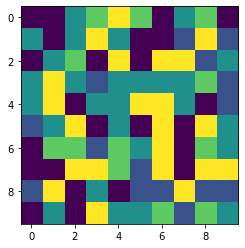

In [136]:
plt.imshow((np.array(runs[f'run{5,0.01,1}'].iloc[0, :100]).reshape(10,10)))

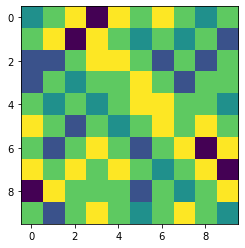

In [138]:
plt.imshow((np.array(runs[f'run{5,0.01,1}'].iloc[1000, :100]).reshape(10,10)))

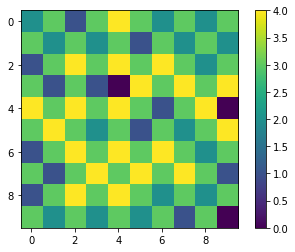

In [139]:
plt.imshow((np.array(runs[f'run{5,0.5,1}'].iloc[-1, :100]).reshape(10,10)))
plt.colorbar()

Text(0.5, 0, 'Number of states')

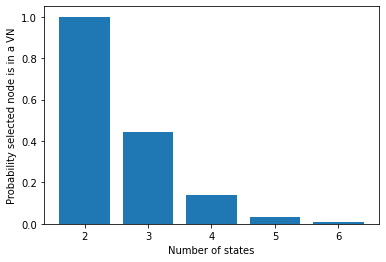

In [128]:
states = np.arange(1,6)
paths = 4*3**(states-1)
    
p = []
states = np.arange(2,7)
i = 0
for path in paths:
    p.append(1/states[i] * path * (1/states[i])**(states[i]-1))
    i+=1
    
plt.bar(states, p) 
plt.xticks(states)
plt.ylabel('Probability selected node is in a VN')
plt.xlabel('Number of states')

Open the experiment data from earlier experiments

In [394]:
# filename = 'VN_count_dict'
# outfile = open(filename,'wb')
# pickle.dump(VN_count_dict, outfile)
# outfile.close()

# filename = 'VN_count_std_dict'
# outfile = open(filename,'wb')
# pickle.dump(VN_count_std_dict, outfile)
# outfile.close()

# filename = 'VN_count_sample'
# outfile = open(filename,'wb')
# pickle.dump(VN_count_sample, outfile)
# outfile.close()

# filename = 'VN_count_sample_nodes'
# outfile = open(filename,'wb')
# pickle.dump(VN_count_sample_nodes, outfile)
# outfile.close()

V_dict = pickle.load(open("experiments_with_V/V_matrices.p", "rb"))

filename = 'VN_count_dict'
infile = open(filename,'rb')
VN_count_dict = pickle.load(infile)
infile.close()

filename = 'VN_count_std_dict'
infile = open(filename,'rb')
VN_count_std_dict = pickle.load(infile)
infile.close()

filename = 'VN_count_sample'
infile = open(filename,'rb')
VN_count_sample = pickle.load(infile)
infile.close()

filename = 'VN_count_sample_nodes'
infile = open(filename,'rb')
VN_count_sample_nodes = pickle.load(infile)
infile.close()

In [7]:
V = V_dict[f'{1}']
V.shape[0]

# # plot the value graph
# g = nx.from_numpy_matrix(V, create_using=nx.DiGraph)
# g.edges()
# nx.draw(g, with_labels=1)

#10 * 1000
ts_arr = np.arange(0, 100000, 100)
np.mean(VN_count_dict[f'{0, 0.01, 0}'])
# print(ts_arr[-1])

42.3

### Local Satisfaction Plots per value network

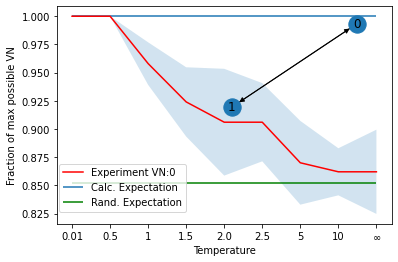

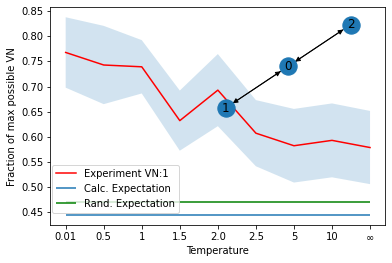

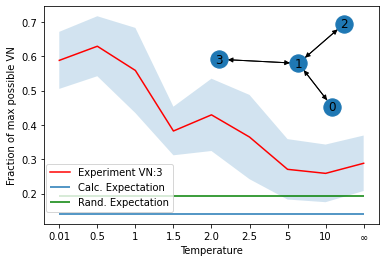

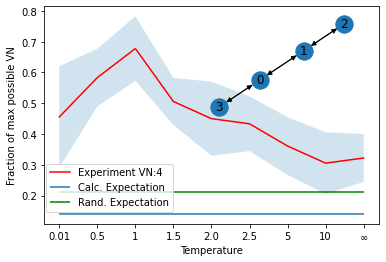

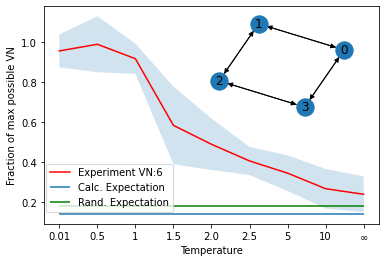

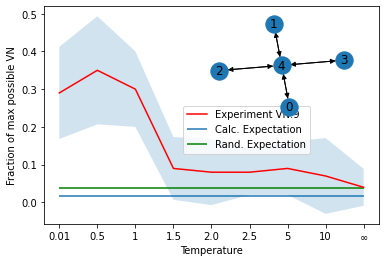

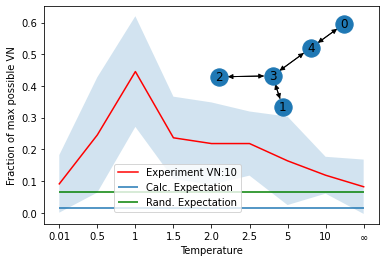

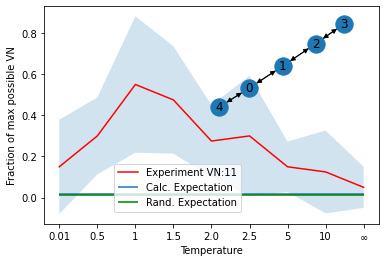

In [57]:
%matplotlib inline
V_list = [0, 1, 3, 4, 6, 9, 10, 11]
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5, 10, np.inf] # np.arange(0.01)
samples = np.arange(0, 10, 1)

V_global_probabilities = [1, 0.4444444444, 0.140625, 0.140625, 0.140625, 0.016, 0.016, 0.016]
V_random_probabilities = [0.85200, 0.46950, 0.19150, 0.21320, 0.18040, 0.037450, 0.0640, 0.01215]
V_SA_max = [50, 28, 17, 18, 18, 10, 11, 4]

ts_arr = np.arange(0, 100000, 100)

diff = {}

for i, V in enumerate(V_list):
    v_matrix = V_dict[f'{V}']

    VN_global = []
    VN_global_std = []
    for j, temp in enumerate(temperatures):
#         VN_global.append(VN_count_dict[f'{V, temp, 0}'][-1]/(100/v_matrix.shape[0]))
#         VN_global.append(np.mean(VN_count_dict[f'{V, temp, ts_arr[-1]}'])/(100/v_matrix.shape[0]))
        VN_global.append(np.mean(VN_count_dict[f'{V, temp, ts_arr[-1]}'])/(V_SA_max[i]))
#         print(VN_global_std_dict[f'{V, temp, ts_arr[-1]}'])
#         VN_global_std.append(VN_count_std_dict[f'{V, temp, ts_arr[-1]}'][-1])
        VN_global_std.append(np.std(VN_count_dict[f'{V, temp, ts_arr[-1]}'])/(V_SA_max[i]))
#         VN_global_std.append(np.std(VN_count_dict[f'{V, temp, ts_arr[-1]}'])/(100/v_matrix.shape[0]))

        diff[f'{V, temp}'] = (VN_global[j] - V_global_probabilities[i])
    
    g = nx.from_numpy_matrix(V_dict[f'{V}'], create_using=nx.DiGraph)
    g.edges()

    fig, ax1 = plt.subplots()

    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.5, 0.5, 0.35, 0.35]
    ax2 = fig.add_axes([left, bottom, width, height])

    ax1.set_xticks(np.arange(9))
    xl = np.array([str(i) for i in temperatures], dtype = object)
    xl[-1] = r"$\infty$"
    ax1.set_xticklabels(xl)
    ax1.plot(xl, VN_global, color='red', label=f'Experiment VN:{V}')
    ax1.hlines(V_global_probabilities[i], 0, 8, label='Calc. Expectation')
    ax1.hlines(V_random_probabilities[i], 0, 8, label='Rand. Expectation', color='green')
    ax1.fill_between(xl, np.array(VN_global) - np.array(VN_global_std), np.array(VN_global) + np.array(VN_global_std), alpha=0.2)
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Fraction of max possible VN')
    ax1.legend(bbox_to_anchor=(0.4,0.3))
    
    nx.draw(g, with_labels=1)
    plt.savefig(f'experiments_with_V/experiment_3/global_satisfaction_temperature/fraction_GlobalSatisfactionVmatrix{V}.png')

### Local and Global Satisfaction plots per value network

2
3
4
4
4
5
5
5


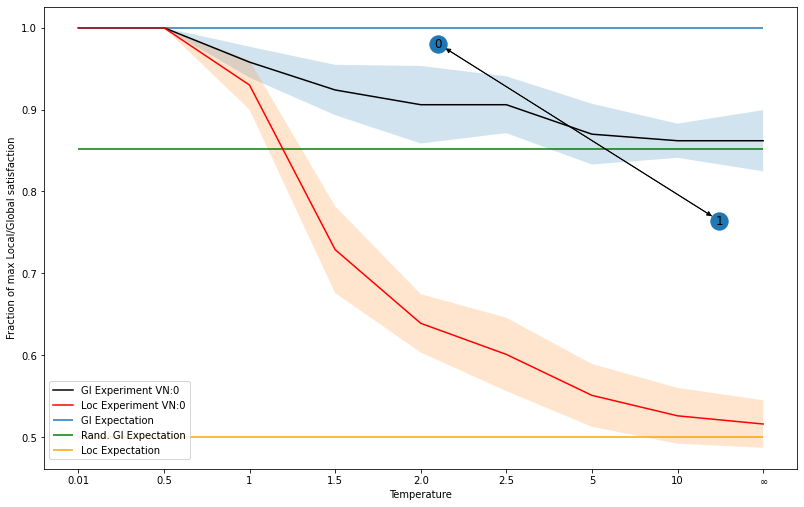

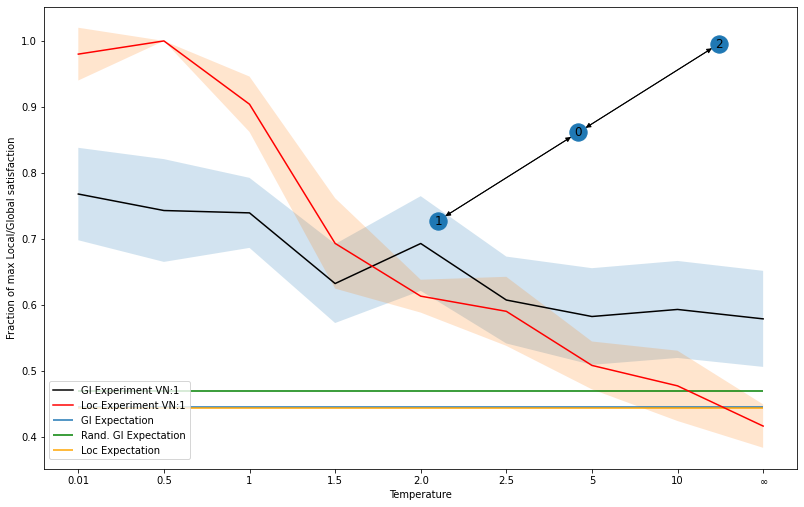

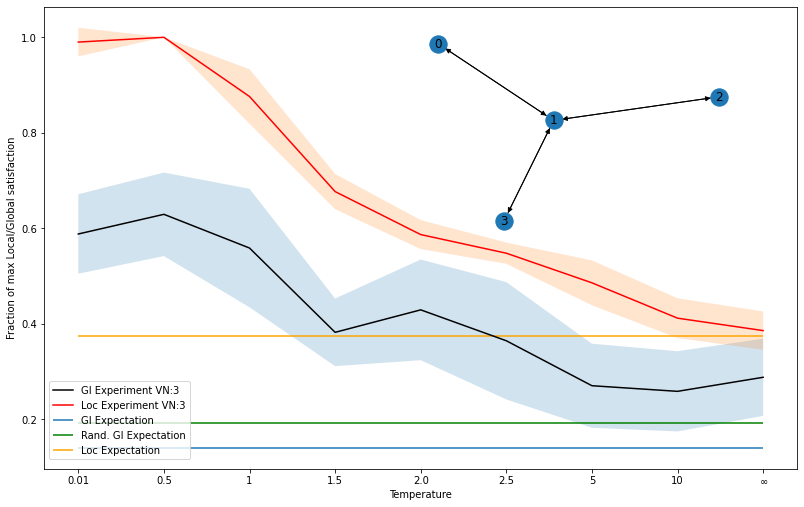

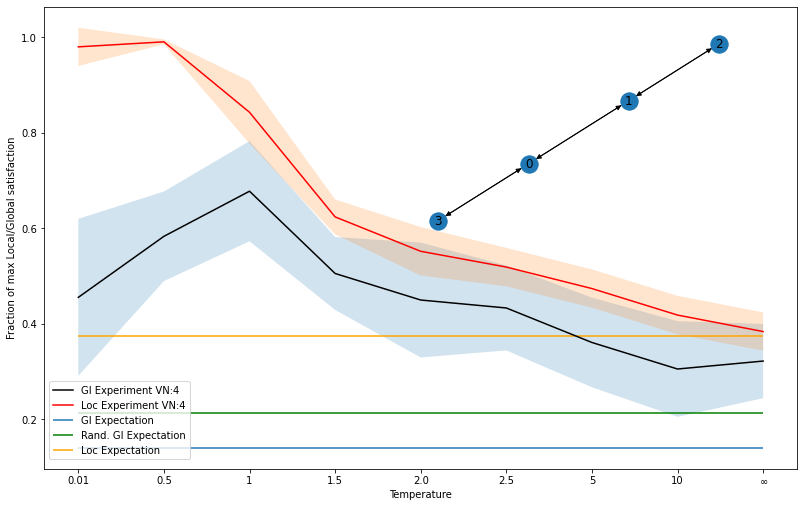

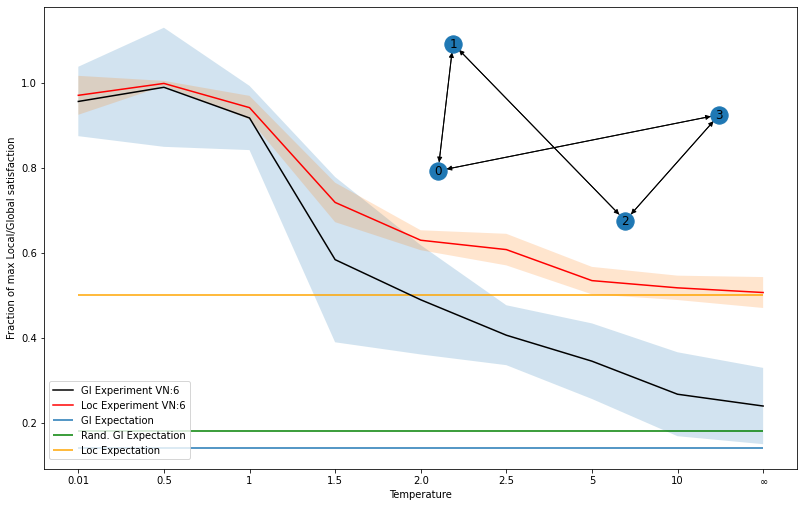

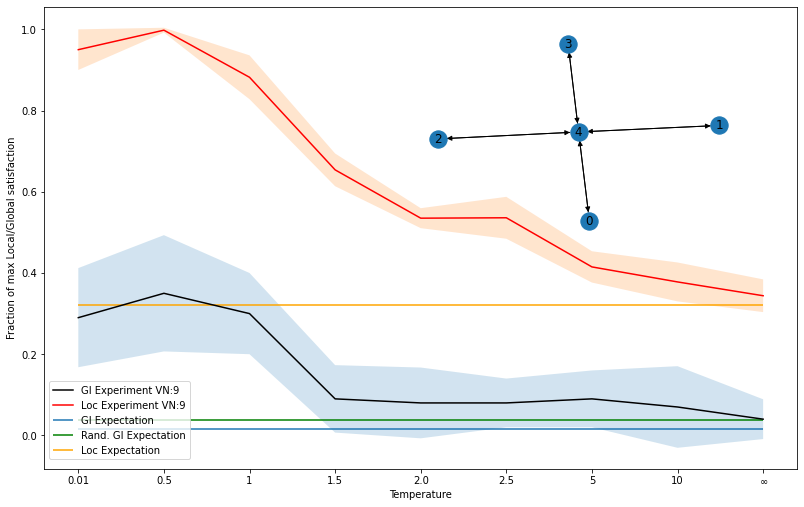

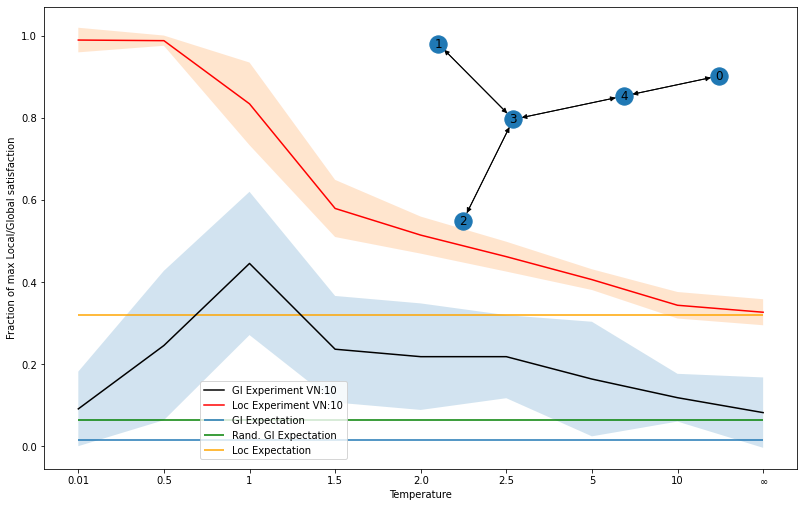

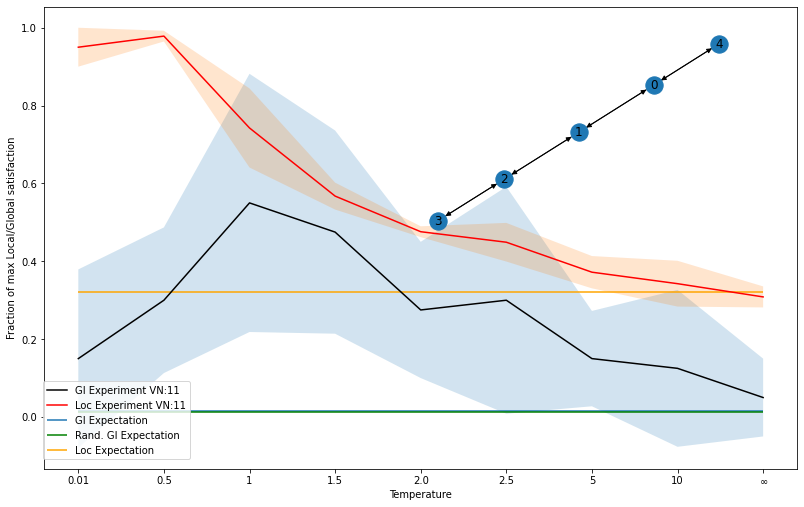

In [94]:
%matplotlib inline
V_list = [0, 1, 3, 4, 6, 9, 10, 11]
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5, 10, np.inf] # np.arange(0.01)
samples = np.arange(0, 10, 1)

V_global_probabilities = [1, 0.4444444444, 0.140625, 0.140625, 0.140625, 0.016, 0.016, 0.016]
V_random_probabilities = [0.85200, 0.46950, 0.19150, 0.21320, 0.18040, 0.037450, 0.0640, 0.01215]
V_local_probabilities = [0.5, 0.444, 0.375, 0.375, 0.5, 0.32, 0.32, 0.32]
V_SA_max = [50, 28, 17, 18, 18, 10, 11, 4]

ts_arr = np.arange(0, 100000, 100)

diff = {}

for i, V in enumerate(V_list):
    v_matrix = V_dict[f'{V}']
    state = v_matrix.shape[0]
    print(state)
    G_init, v_matrix, system_hamiltonian, A, fm = simulate(1, state, v_matrix, 1)

    filename = f'experiments_with_V/experiment_3/vmatrixrun_{V}'
    infile = open(filename, 'rb')
    runs = pickle.load(infile)
    infile.close()
    
    VN_global = []
    VN_global_std = []
    
    mean_local_satisfaction = []
    mean_local_error = []
    for j, temp in enumerate(temperatures):
        
        # Global Satisfaction
        VN_global.append(np.mean(VN_count_dict[f'{V, temp, ts_arr[-1]}'])/(V_SA_max[i]))
        VN_global_std.append(np.std(VN_count_dict[f'{V, temp, ts_arr[-1]}'])/(V_SA_max[i]))
        diff[f'{V, temp}'] = (VN_global[j] - V_global_probabilities[i])

        # Local Satisfaction
        avg = []

        for run in samples:
            arr = np.array(runs[f'run{state,temp,run}'].iloc[-1, :100])
            avg.append(check_local(arr, A, v_matrix)/4)
        mean_local_satisfaction.append(np.mean(avg))
        mean_local_error.append(np.std(avg))
    
    g = nx.from_numpy_matrix(V_dict[f'{V}'], create_using=nx.DiGraph)
    g.edges()

    fig, ax1 = plt.subplots()
    fig.set_size_inches(13.5, 8.5)

    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.5, 0.5, 0.35, 0.35]
    ax2 = fig.add_axes([left, bottom, width, height])

    ax1.set_xticks(np.arange(9))
    xl = np.array([str(i) for i in temperatures], dtype = object)
    xl[-1] = r"$\infty$"
    ax1.set_xticklabels(xl)
    ax1.plot(xl, VN_global, color='black', label=f'Gl Experiment VN:{V}')
    ax1.hlines(V_global_probabilities[i], 0, 8, label='Gl Expectation')
    ax1.hlines(V_random_probabilities[i], 0, 8, label='Rand. Gl Expectation', color='green')
    ax1.fill_between(xl, np.array(VN_global) - np.array(VN_global_std), np.array(VN_global) + np.array(VN_global_std), alpha=0.2)
    
    ax1.plot(xl, mean_local_satisfaction, color='red', label=f'Loc Experiment VN:{V}')
    ax1.hlines(V_local_probabilities[i], 0, 8, label='Loc Expectation', color='orange')
    ax1.fill_between(xl, np.array(mean_local_satisfaction) - np.array(mean_local_error), np.array(mean_local_satisfaction) + np.array(mean_local_error), alpha=0.2)
    
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Fraction of max Local/Global satisfaction')
    ax1.legend(bbox_to_anchor=(0.2,0.2))
    
    nx.draw(g, with_labels=1)
    plt.savefig(f'experiments_with_V/experiment_3/global_satisfaction_temperature/fraction_GlobalSatisfactionVmatrix{V}.png')

2
[1.0, 1.0, 0.9299999999999999, 0.7289999999999999, 0.639, 0.601, 0.5509999999999999, 0.526, 0.516] [0.0, 0.0, 0.029999999999999978, 0.053000000000000005, 0.035623026261113785, 0.04482186966202994, 0.038327535793473595, 0.034117444218463966, 0.029051678092667916]
3
[0.9800000000000001, 1.0, 0.9039999999999999, 0.6930000000000001, 0.6130000000000001, 0.5900000000000001, 0.508, 0.477, 0.41600000000000004] [0.039999999999999994, 0.0, 0.04200000000000001, 0.06856383886568779, 0.024919871588754246, 0.05234500931320961, 0.03627671429443411, 0.05330103188494572, 0.03292415526630866]


<ipython-input-105-0fa8e9940568>:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_axes([left, bottom, width, height])
<ipython-input-105-0fa8e9940568>:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_axes([left, bottom, width, height])


<Figure size 432x288 with 0 Axes>

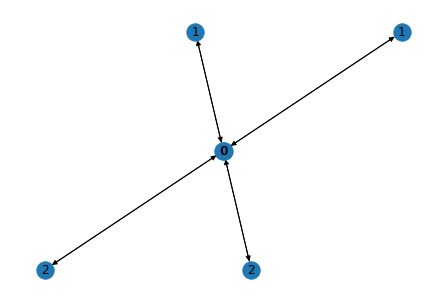

In [105]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import networkx as nx

V_list = [0, 1] #, 3, 4, 6, 9, 10, 11]
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5, 10, np.inf] # np.arange(0.01)
samples = np.arange(0, 10, 1)
timesteps = 10000

V_local_probabilities = [0.5, 0.444, 0.375, 0.375, 0.5, 0.32, 0.32, 0.32]

V_dict = pickle.load(open("experiments_with_V/V_matrices.p", "rb"))

# iterate through value networks
for i, v in enumerate(V_list):
    v_matrix = V_dict[f'{v}']
    state = v_matrix.shape[0]
    print(state)
    G_init, v_matrix, system_hamiltonian, A, fm = simulate(1, state, v_matrix, 1)

    filename = f'experiments_with_V/experiment_3/vmatrixrun_{v}'
    infile = open(filename, 'rb')
    runs = pickle.load(infile)
    infile.close()

    mean_local_satisfaction = []
    mean_local_error = []
    plt.figure()
    
    # iterate through temperatures
    for temp in temperatures:
        fh = 0
        sh = 0
        satisfaction = 0
        avg = []
        for run in samples:
            # print(len(np.array(runs[f'run{state, temp, run}'])))
            arr = np.array(runs[f'run{state,temp,run}'].iloc[-1, :100])
            avg.append(check_local(arr, A, v_matrix)/4)
        mean_local_satisfaction.append(np.mean(avg))
        mean_local_error.append(np.std(avg))

    print(mean_local_satisfaction, mean_local_error)

# fig, ax1 = plt.figure()
for i, v in enumerate(V_list):
    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.5, 0.5, 0.35, 0.35]
    ax2 = fig.add_axes([left, bottom, width, height])

    ax1.set_xticks(np.arange(len(temperatures)))
    xl = np.array([str(k) for k in temperatures], dtype=object)
    xl[-1] = r"$\infty$"
    ax1.set_xticklabels(xl)
    ax1.plot(xl, mean_local_satisfaction, color='red', label=f'VN:{v}')
    ax1.hlines(V_local_probabilities[i], 0, 8, label='Probability')
    ax1.fill_between(xl, np.array(mean_local_satisfaction) - np.array(mean_local_error), np.array(mean_local_satisfaction) + np.array(mean_local_error), alpha=0.2)
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Average local satisfaction')
    ax1.set_title(f'Local Satisfaction VN: {v}')
    ax1.legend(bbox_to_anchor=(0.4, 0.3))

    g = nx.from_numpy_matrix(v_matrix, create_using=nx.DiGraph)
    g.edges()
    nx.draw(g, with_labels=1)


    # plt.plot(temperatures, mean_local_satisfaction, label=f'V Matrix:{v}')
    # plt.fill_between(temperatures, np.array(mean_local_satisfaction) - np.array(mean_local_error), np.array(mean_local_satisfaction) + np.array(mean_local_error), facecolor='#FF9848')
    # plt.ylabel('average satisfaction of all nodes')
    # plt.xlabel('Temperature')
    # plt.title(f'Local Satisfaction V matrix: {v}')
    # plt.legend()
#     plt.savefig(f'experiments_with_V/experiment_3/local_satisfactions/LocalSatisfactionVmatrix:{v}')

In [477]:
local_satisfaction_dict = {}

V_list = [0, 1, 3, 4, 6, 9, 10, 11]
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5, 10, np.inf] # np.arange(0.01)
samples = np.arange(0, 10, 1)
timesteps = 10000

V_local_probabilities = [0.5, 0.444, 0.375, 0.375, 0.5, 0.32, 0.32, 0.32]

V_dict = pickle.load(open("experiments_with_V/V_matrices.p", "rb"))
for i, v in enumerate(V_list):
    v_matrix = V_dict[f'{v}']
    state = v_matrix.shape[0]
    print(state)
    G_init, v_matrix, system_hamiltonian, A, fm = simulate(1, state, v_matrix, 1)

    filename = f'experiments_with_V/experiment_3/vmatrixrun_{v}'
    infile = open(filename, 'rb')
    runs = pickle.load(infile)
    infile.close()

    mean_local_satisfaction = []
    mean_local_error = []
    all_local_satisfactions = []
    
    for temp in temperatures:
        fh = 0
        sh = 0
        satisfaction = 0
        avg = []
        for run in samples:
            # print(len(np.array(runs[f'run{state, temp, run}'])))
            arr = np.array(runs[f'run{state,temp,run}'].iloc[-1, :100])
            avg.append(check_local(arr, A, v_matrix)/4)
        mean_local_satisfaction.append(np.mean(avg))
        mean_local_error.append(np.std(avg))
        all_local_satisfactions.append(avg)

    #         print(mean_local_satisfaction, mean_local_error)
        local_satisfaction_dict[f'mean{v, temp}'] = mean_local_satisfaction
        local_satisfaction_dict[f'error{v, temp}'] = mean_local_error
        local_satisfaction_dict[f'all{v, temp}'] = all_local_satisfactions

    # local_satisfaction_dict
    

2
3
4
4
4
5
5
5


In [478]:
for key in local_satisfaction_dict.keys():
    print(key)

mean(0, 0.01)
error(0, 0.01)
all(0, 0.01)
mean(0, 0.5)
error(0, 0.5)
all(0, 0.5)
mean(0, 1)
error(0, 1)
all(0, 1)
mean(0, 1.5)
error(0, 1.5)
all(0, 1.5)
mean(0, 2.0)
error(0, 2.0)
all(0, 2.0)
mean(0, 2.5)
error(0, 2.5)
all(0, 2.5)
mean(0, 5)
error(0, 5)
all(0, 5)
mean(0, 10)
error(0, 10)
all(0, 10)
mean(0, inf)
error(0, inf)
all(0, inf)
mean(1, 0.01)
error(1, 0.01)
all(1, 0.01)
mean(1, 0.5)
error(1, 0.5)
all(1, 0.5)
mean(1, 1)
error(1, 1)
all(1, 1)
mean(1, 1.5)
error(1, 1.5)
all(1, 1.5)
mean(1, 2.0)
error(1, 2.0)
all(1, 2.0)
mean(1, 2.5)
error(1, 2.5)
all(1, 2.5)
mean(1, 5)
error(1, 5)
all(1, 5)
mean(1, 10)
error(1, 10)
all(1, 10)
mean(1, inf)
error(1, inf)
all(1, inf)
mean(3, 0.01)
error(3, 0.01)
all(3, 0.01)
mean(3, 0.5)
error(3, 0.5)
all(3, 0.5)
mean(3, 1)
error(3, 1)
all(3, 1)
mean(3, 1.5)
error(3, 1.5)
all(3, 1.5)
mean(3, 2.0)
error(3, 2.0)
all(3, 2.0)
mean(3, 2.5)
error(3, 2.5)
all(3, 2.5)
mean(3, 5)
error(3, 5)
all(3, 5)
mean(3, 10)
error(3, 10)
all(3, 10)
mean(3, inf)
error(3, 

### Local Satisfaction plot for all value networks and all temperatures

['0.01' '0.5' '1' '1.5' '2.0' '2.5' '5' '10' '$\\infty$']


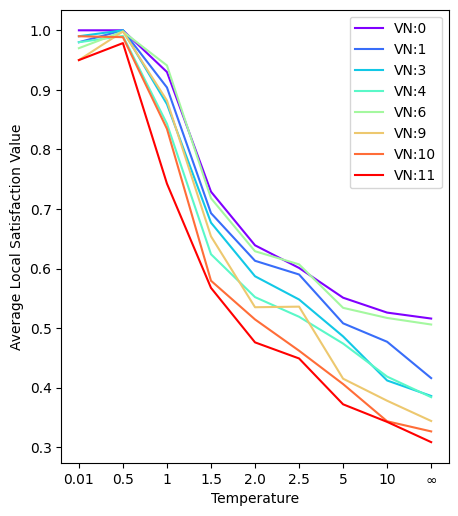

In [485]:
color = cm.rainbow(np.linspace(0,1,8))

fig, ax = plt.subplots(figsize=(5,6), dpi = 100)
for i, v in enumerate(V_list):
#     print(local_satisfaction_dict[f'mean{v, temp}'])
    plt.plot(local_satisfaction_dict[f'mean{v, temp}'], label=f'VN:{v}', color=color[i])
#     plt.plot(np.array(local_satisfaction_dict[f'mean{v, temp}']) - np.array(local_satisfaction_dict[f'error{v, temp}']), '--', color=color[i])
#     plt.plot(np.array(local_satisfaction_dict[f'mean{v, temp}']) + np.array(local_satisfaction_dict[f'error{v, temp}']), '--', color=color[i])
    plt.ylabel('Average Local Satisfaction Value')
    plt.xlabel('Temperature')
    plt.legend()

ax.set_xticks(np.arange(len(temperatures)))
xl = np.array([str(k) for k in temperatures], dtype=object)
xl[-1] = r"$\infty$"
ax.set_xticklabels(xl)
print(xl)

### Error between local satisfaction of the value network model and expected local satisfaction when states are i.i.d. random. 

<ipython-input-492-9d3ac2139661>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax7.set_xticklabels(xl)


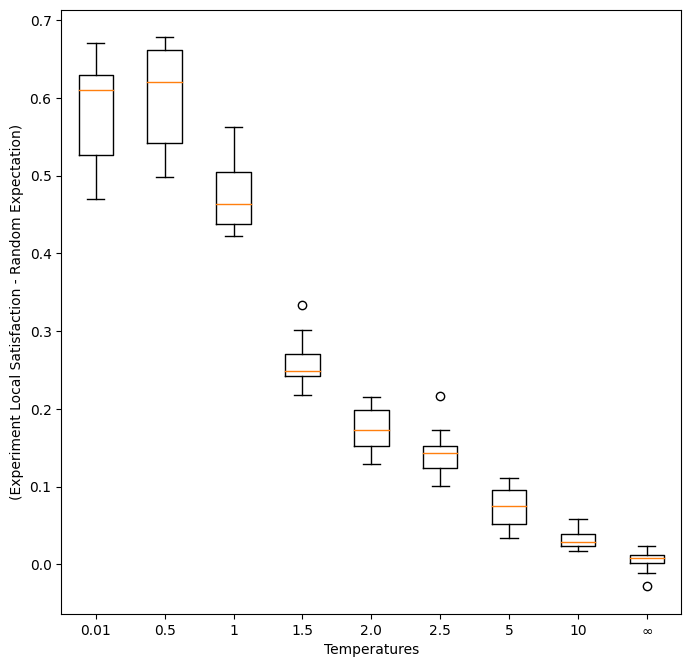

In [492]:
fig7, ax7 = plt.subplots(figsize=(8,8), dpi = 100)
# ax7.set_title('Difference Experiment and Random Expectation')
ax7.set_xlabel('Temperatures')
ax7.set_ylabel('(Experiment Local Satisfaction - Random Expectation)')
ax7.set_xticklabels(xl)

sep_list = []
for j, temp in enumerate(temperatures):
    data = []
    for i, v in enumerate(V_list):
#         print(v, temp, local_satisfaction_dict[f'mean{v, temp}'][i])
        diff = local_satisfaction_dict[f'mean{v, temp}'][j] - V_local_probabilities[i]
        data.append(diff)
    sep_list.append(data)
ax7.boxplot(sep_list)

plt.savefig('local_temp_error.png', dpi = 1000)

### Global Satisfaction plots

In [495]:
%matplotlib inline
V_list = [0, 1, 3, 4, 6, 9, 10, 11]
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5, 10, np.inf] # np.arange(0.01)
samples = np.arange(0, 10, 1)

V_global_probabilities = [1, 0.4444444444, 0.140625, 0.140625, 0.140625, 0.016, 0.016, 0.016]
V_random_probabilities = [0.85200, 0.46950, 0.19150, 0.21320, 0.18040, 0.037450, 0.0640, 0.01215]
V_SA_max = [50, 31, 17, 18, 20, 9, 11, 7]

ts_arr = np.arange(0, 100000, 100)

diff = {}

fig, ax1 = plt.subplots(figsize=(8,8), dpi=1000)
ax1.set_xticks(np.arange(9))
xl = np.array([str(i) for i in temperatures], dtype = object)
xl[-1] = r"$\infty$"
ax1.set_xticklabels(xl)

for i, V in enumerate(V_list):
    v_matrix = V_dict[f'{V}']

    VN_global = []
    VN_global_std = []
    for j, temp in enumerate(temperatures):
#         VN_global.append(VN_count_dict[f'{V, temp, 0}'][-1]/(100/v_matrix.shape[0]))
#         VN_global.append(np.mean(VN_count_dict[f'{V, temp, ts_arr[-1]}'])/(100/v_matrix.shape[0]))
        VN_global.append(np.mean(VN_count_dict[f'{V, temp, ts_arr[-1]}'])/(V_SA_max[i]))
#         print(VN_global_std_dict[f'{V, temp, ts_arr[-1]}'])
#         VN_global_std.append(VN_count_std_dict[f'{V, temp, ts_arr[-1]}'][-1])
        VN_global_std.append(np.std(VN_count_dict[f'{V, temp, ts_arr[-1]}'])/(V_SA_max[i]))
#         VN_global_std.append(np.std(VN_count_dict[f'{V, temp, ts_arr[-1]}'])/(100/v_matrix.shape[0]))

        diff[f'{V, temp}'] = (VN_global[j] - V_global_probabilities[i])
    
    g = nx.from_numpy_matrix(V_dict[f'{V}'], create_using=nx.DiGraph)
    g.edges()
    ax1.plot(xl, VN_global, label=f'Experiment VN:{V}', color=color[i])
#     ax1.fill_between(xl, np.array(VN_global) - np.array(VN_global_std), np.array(VN_global) + np.array(VN_global_std), alpha=0.2)
#     ax1.plot(xl, np.array(VN_global) - np.array(VN_global_std), '--', color=color[i])
#     ax1.plot(xl, np.array(VN_global) + np.array(VN_global_std), '--', color=color[i])
    
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.5, 0.5, 0.35, 0.35]
# ax2 = fig.add_axes([left, bottom, width, height])

# ax1.set_xticks(np.arange(9))
# xl = np.array([str(i) for i in temperatures], dtype = object)
# xl[-1] = r"$\infty$"
# ax1.set_xticklabels(xl)
# ax1.hlines(V_global_probabilities[i], 0, 8, label='Calc. Expectation')
# ax1.hlines(V_random_probabilities[i], 0, 8, label='Rand. Expectation', color='green')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Global Satisfaction Value')
ax1.legend(bbox_to_anchor=(1,0.3))

# nx.draw(g, with_labels=1)
# plt.savefig(f'experiments_with_V/experiment_3/global_satisfaction_temperature/fraction_GlobalSatisfactionVmatrix{V}.png')
plt.savefig('global_satisfaction_all.png', dpi = 1000)

In [460]:
diff = {}
V_list = [0, 1, 3, 4, 6, 9, 10, 11]

V_global_probabilities = [1, 0.4444444444, 0.140625, 0.140625, 0.140625, 0.016, 0.016, 0.016]

for key in diff.keys():
    diff[f'{key}'] = np.mean(diff[f'{key}'])


for i, V in enumerate(V_list):
    v_matrix = V_dict[f'{V}']
    for j, temp in enumerate(temperatures):
        error = []
        for run in samples:
#             print(i, V,  V_global_probabilities[i])
            if VN_count_dict[f'{V, temp, ts_arr[-1]}'][run]/(V_SA_max[i]) - V_global_probabilities[i] > 1:
                print(V, temp, ts_arr[-1], run)
            else:
                error.append(VN_count_dict[f'{V, temp, ts_arr[-1]}'][run]/(V_SA_max[i]) - V_global_probabilities[i])
        diff[f'{V, temp}'] = error

In [461]:
global_sat = {}
V_list = [0, 1, 3, 4, 6, 9, 10, 11]

V_global_probabilities = [1, 0.4444444444, 0.140625, 0.140625, 0.140625, 0.016, 0.016, 0.016]

for key in diff.keys():
    diff[f'{key}'] = np.mean(diff[f'{key}'])


for i, V in enumerate(V_list):
    v_matrix = V_dict[f'{V}']
    for j, temp in enumerate(temperatures):
        error = []
        for run in samples:
#             print(i, V,  V_global_probabilities[i])
            error.append(VN_count_dict[f'{V, temp, ts_arr[-1]}'][run]/(V_SA_max[i]))
            
        global_sat[f'{V, temp}'] = error

In [462]:
global_sat2 = np.zeros((len(temperatures), len(V_list)))
for i, temp in enumerate(temperatures):
    for j, v in enumerate(V_list):
        vs.append(v)
        ts.append(temp)
        global_sat2[i][j] = np.mean(global_sat[f'{v, temp}'])

In [463]:
# np.mean(VN_count_dict['(1, inf, 99000)'])/(V_SA_max[1]) - V_global_probabilities[1]
# for j, temp in enumerate(temperatures):
#     for i, V in enumerate(V_list):
#         for x in diff[f'{V, temp}']:
#             print("x", x)
#             if x > 1:
#                 print("x")
# #         print(diff[f'{V, temp}'])

### Difference value network model Global Satisfaction and expected global satisfaction when node-states are i.i.d. random.

<ipython-input-464-591fbae0157d>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax7.set_xticklabels(xl)


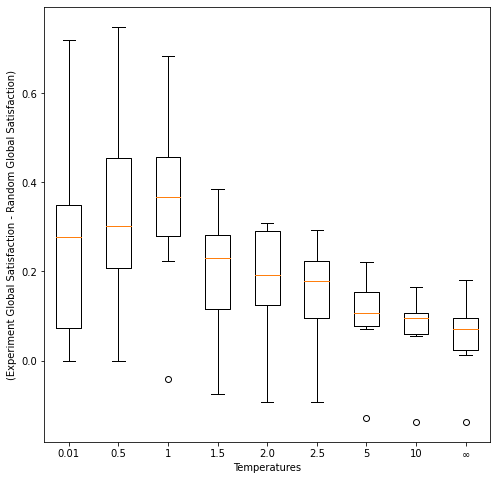

In [464]:
xl = np.array([str(i) for i in temperatures], dtype = object)
xl[-1] = r"$\infty$"

fig7, ax7 = plt.subplots(figsize=(8,8))
ax7.set_xlabel('Temperatures')
ax7.set_ylabel('(Experiment Global Satisfaction - Random Global Satisfaction)')
ax7.set_xticklabels(xl)

sep_list = []
for j, temp in enumerate(temperatures):
    data = []
    for i, V in enumerate(V_list):
#         print(V, temp, diff[f'{V, temp}'])
        data.append(diff[f'{V, temp}'])
    sep_list.append(data)
ax7.boxplot(sep_list)

plt.savefig('global_temp_error.png', dpi = 1000)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fac1be6a550>,
 'caps': [<matplotlib.lines.Line2D at 0x7fac1be6abe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fac1be12b20>,
 'medians': [<matplotlib.lines.Line2D at 0x7fac1bf64250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fac1bf64580>,
 'means': []}

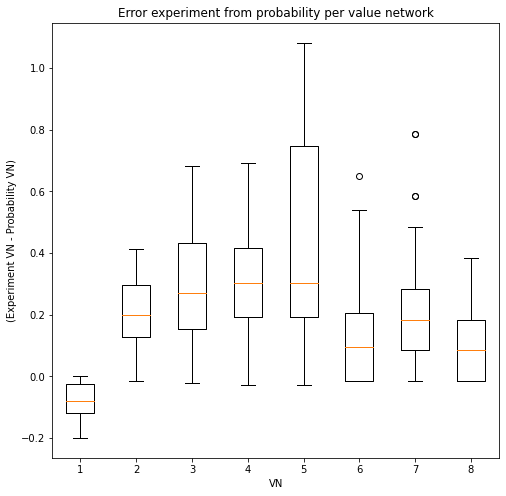

In [20]:
fig7, ax7 = plt.subplots(figsize=(8,8))
ax7.set_title('Error experiment from probability per value network')
ax7.set_xlabel('VN')
ax7.set_ylabel('(Experiment VN - Probability VN)')

sep_list = []
for i, V in enumerate(V_list):
    data = []
    for j, temp in enumerate(temperatures):
        data.extend(diff[f'{V, temp}'])
#         print("data", V, temp, data)
    sep_list.append(data)
ax7.boxplot(sep_list)

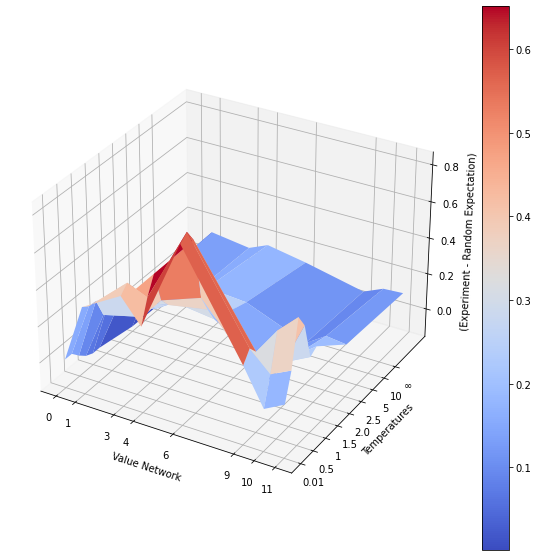

In [261]:
V_list = [0, 1, 3, 4, 6, 9, 10, 11]
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5, 10, np.inf]

vs = []
ts = []
difference = np.zeros((len(temperatures), len(V_list)))
for i, temp in enumerate(temperatures):
    for j, v in enumerate(V_list):
        vs.append(v)
        ts.append(temp)
        difference[i][j] = np.mean(diff[f'{v, temp}'])
        
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
# Creating dataset
x = V_list
y = temperatures
x, y = np.meshgrid(x, y)
z = difference

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')   # Create the axes

# Plot the 3d surface
surface = ax.plot_surface(x, y, z,
                          cmap=cm.coolwarm,
                          rstride = 1,
                          cstride = 1)

# Set some labels
ax.set_yticks(np.arange(len(temperatures)))
yl = np.array([str(i) for i in temperatures], dtype = object)
yl[-1] = r"$\infty$"
ax.set_yticklabels(yl)

ax.set_xticks(np.arange(len(V_list)))
xl = np.array([str(i) for i in V_list], dtype = object)
ax.set_xticks(V_list)

ax.set_xlabel('Value Network')
ax.set_ylabel('Temperatures')
ax.set_zlabel('(Experiment - Random Expectation)')

fig.colorbar(surface)

# for angle in range(0, 360):
#     ax.view_init(90, angle)
#     plt.draw()
#     plt.pause(.001)
    
plt.show()

In [321]:
# fig, ax = plt.subplots(figsize=(10,10))
# plt.imshow(difference, cmap=cm.coolwarm)
# plt.colorbar()
# plt.title('Difference Experimental and Random Expectation')

# ax.set_yticks(np.arange(len(temperatures)))
# yl = np.array([str(i) for i in temperatures], dtype = object)
# yl[-1] = r"$\infty$"
# ax.set_yticklabels(yl)
# ax.set_ylabel('Temperatures')

# ax.set_xticks(np.arange(len(V_list)))
# xl = np.array([str(i) for i in V_list], dtype = object)
# ax.set_xticklabels(xl)
# ax.set_xlabel('Value Network')
# plt.savefig('2d_error.png', dpi = 1000)

### Absolute error between global expectation and experimental results

In [496]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

df = DataFrame(difference, index=temperatures, columns=V_list)

f, ax = plt.subplots(figsize=(10, 10), dpi=1000)
ax = sns.heatmap(df, annot=True, cmap=cm.coolwarm, linewidths=.5)

# ax.set_yticks(np.arange(len(temperatures)))
yl = np.array([str(i) for i in temperatures], dtype = object)
yl[-1] = r"$\infty$"
ax.set_yticklabels(yl)
ax.set_ylabel('Temperatures')

# ax.set_xticks(np.arange(len(V_list)))
xl = np.array([str(i) for i in V_list], dtype = object)
ax.set_xticklabels(xl)
ax.set_xlabel('Value Network')

plt.title('Difference Experimental and Random Expectation')
plt.savefig('2d_error.png', dpi = 1000)

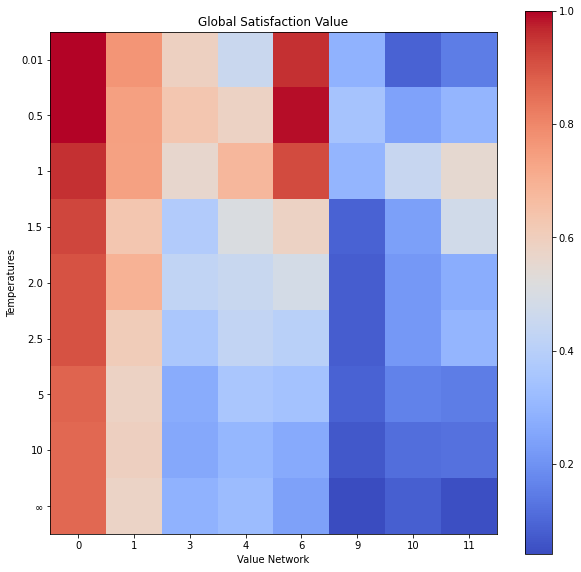

In [307]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(global_sat2, cmap=cm.coolwarm)
plt.colorbar()
plt.title('Global Satisfaction Value')

ax.set_yticks(np.arange(len(temperatures)))
yl = np.array([str(i) for i in temperatures], dtype = object)
yl[-1] = r"$\infty$"
ax.set_yticklabels(yl)
ax.set_ylabel('Temperatures')

ax.set_xticks(np.arange(len(V_list)))
xl = np.array([str(i) for i in V_list], dtype = object)
ax.set_xticklabels(xl)
ax.set_xlabel('Value Network')
plt.savefig('2d_absolute.png', dpi = 1000)

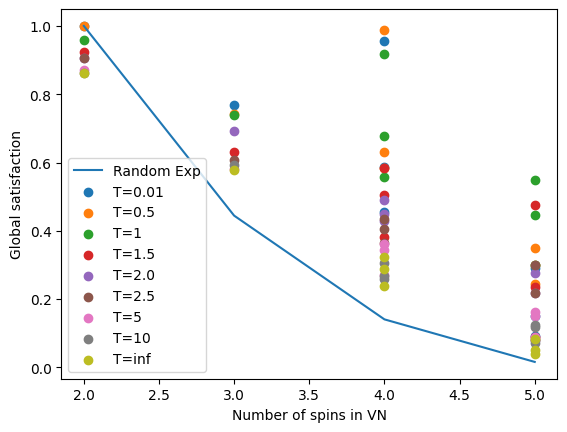

In [278]:
# %matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
V_global_probabilities = [1, 0.4444444444, 0.140625, 0.140625, 0.140625, 0.016, 0.016, 0.016]
V_states = [2, 3, 4, 4, 4, 5, 5, 5]
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5, 10, np.inf]
V_global_experiment = []

for temp in temperatures:
    V_global_experiment = []
    for i, V in enumerate(V_list):
        v_matrix = V_dict[f'{V}']
        V_global_experiment.append(np.mean(VN_count_dict[f'{V, temp, ts_arr[-1]}'])/(V_SA_max[i]))
    plt.scatter(V_states, V_global_experiment, label=f'T={temp}')
    plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)

plt.plot(V_states, V_global_probabilities, label='Random Exp')
plt.legend()
plt.xlabel('Number of spins in VN')
plt.ylabel('Global satisfaction')
# plt.rcParams["figure.figsize"]= 15,15
# plt.figure(figsize= (15,15))
fig.patch.set_facecolor('blue')
plt.savefig(f'experiments_with_V/experiment_2/VN_numberStates2.png', transparent=False)


In [62]:
V_list = [0, 1, 3, 4, 6, 9, 10, 11]
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5, 10, np.inf] # np.arange(0.01)
samples = np.arange(0, 10, 1)
ts_arr = np.arange(0, 100000, 100)

VN_temporal = np.zeros((1000, 100))
# VN_count_sample_nodes['(6, 0.01, 99000, 0)']

VN_count_sample_nodes_vector = {}

for V in V_list:
    for temp in temperatures:
        for run in samples:
            VN_temporal = np.zeros((1000, 100))
            for i, timestep in enumerate(ts_arr):
                nodes = VN_count_sample_nodes[f'{V, temp, timestep, run}']
                for node in nodes:
                    VN_temporal[i, node] = 1
            VN_count_sample_nodes_vector[f'{V, temp, run}'] = VN_temporal
            

In [63]:
import os
import numpy as np
import matplotlib.pyplot as plt
    
for i, timestep in enumerate(ts_arr):
    VN_count_sample_nodes_vector['(0, 0.01, 0)'][i].reshape(10,10)
    
# print(VN_count_sample_nodes_vector['(11, inf, 0)'][i].reshape(10,10))
# plt.imshow(VN_count_sample_nodes_vector['(11, inf, 0)'][i].reshape(10,10))
# plt.imshow(VN_count_sample_nodes_vector['(3, 0.01, 0)'][100].reshape(10,10))

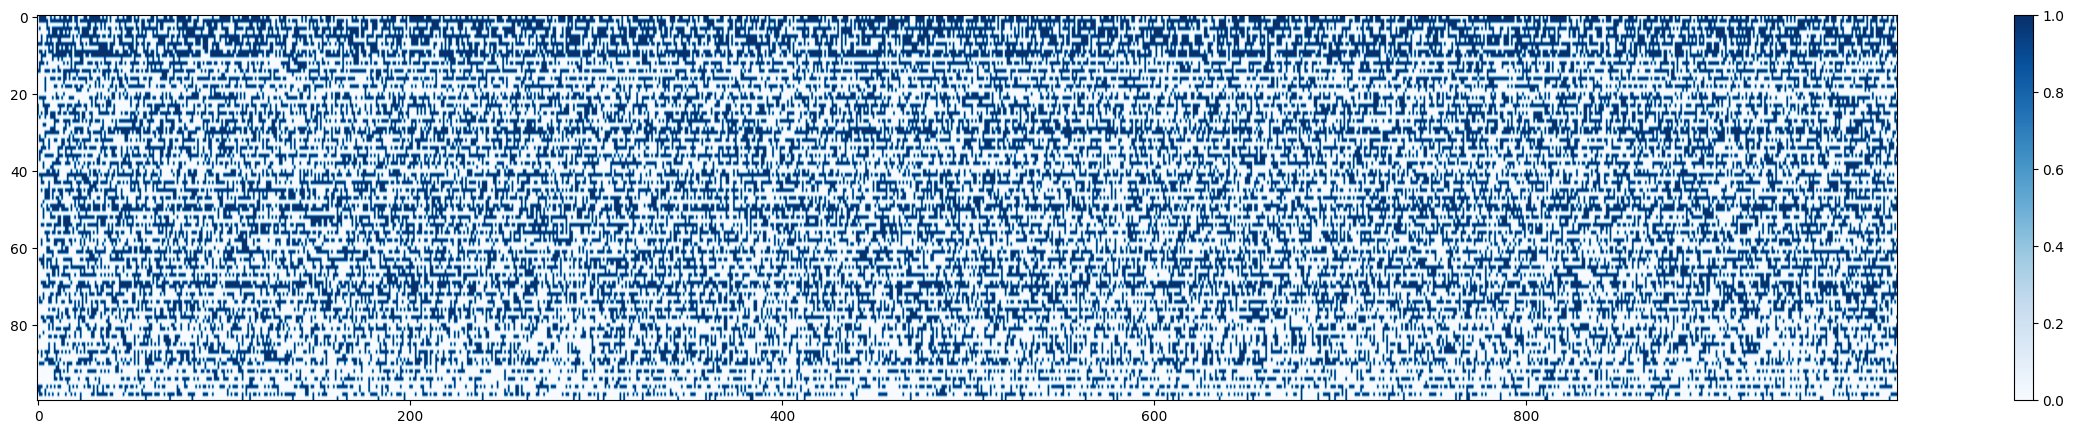

In [584]:
fig, ax1 = plt.subplots(figsize=(30,5))
img = ax1.imshow(VN_count_sample_nodes_vector['(3, 0.01, 0)'].T, cmap='Blues', aspect='auto')
# ax1.set_xticks([0, 20, 40, 60, 80, 100])
# ax1.set_xticklabels([0, 20, 40, 60, 80, 100])
fig.colorbar(img)

plt.show()

### What is the average time a node is in a value network?

9 9


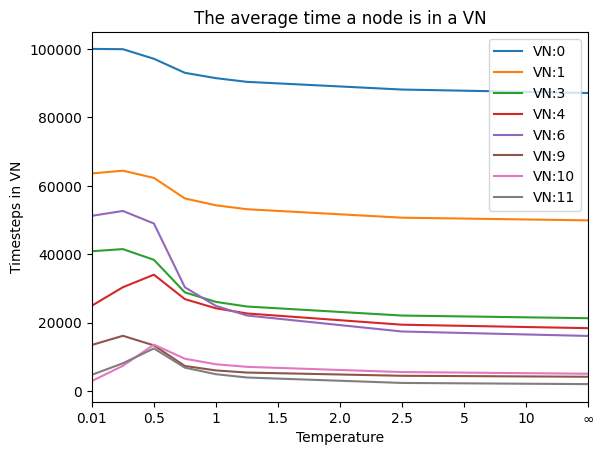

In [376]:
temp_time_in_VN = []
avg_time_in_VN = []
V_list = [0, 1, 3, 4, 6, 9, 10, 11]

fig, ax1 = plt.subplots()
# ax1.set_xticks(np.arange(9))
xl = np.array([str(i) for i in temperatures], dtype = object)
xl[-1] = r"$\infty$"
ax1.set_xticks(range(len(xl)))
ax1.set_xticklabels(xl)

plt.title('The average time a node is in a VN')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Timesteps in VN')

for v in V_list:
    temp_time_in_VN = []
    for temp in temperatures:
        avg_time_in_VN = []
        for run in samples:
            for node in range(100):
                avg_time_in_VN.append(np.count_nonzero(VN_count_sample_nodes_vector[f'({v}, {temp}, {run})'][:,node]))
        temp_time_in_VN.append(np.mean(avg_time_in_VN))

    temp_time_in_VN = [avg*100 for avg in temp_time_in_VN]
    plt.plot(temperatures, temp_time_in_VN, label=f'VN:{v}')
    plt.xlim(0, 8)
ax1.legend()

print(len(temperatures), len(temp_time_in_VN))

### What is the longest consuctive time a node is in a VN?

Text(0.5, 1.0, 'Longest consecutive time node in VN (n=10)')

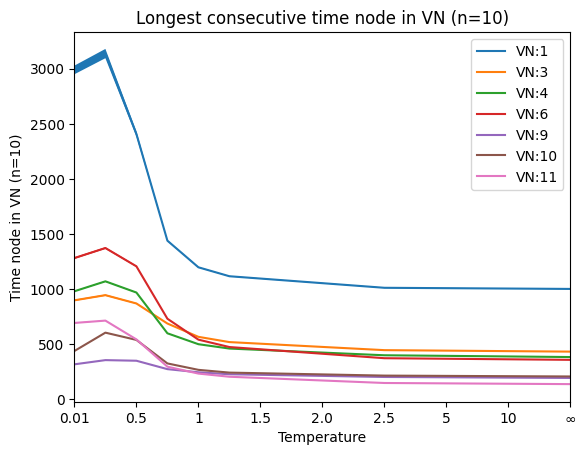

In [377]:
temp_time_in_VN = []
avg_max_time_in_VN = []

def getMaxLength(arr, n):
    # intitialize count
    count = 0 
      
    # initialize max
    result = 0 
  
    for i in range(0, n):
      
        # Reset count when 0 is found
        if (arr[i] == 0):
            count = 0
  
        # If 1 is found, increment count
        # and update result if count 
        # becomes more.
        else:
              
            # increase count
            count+= 1 
            result = max(result, count) 
          
    return result 

fig, ax1 = plt.subplots()
# ax1.set_xticks(np.arange(9))
xl = np.array([str(i) for i in temperatures], dtype = object)
xl[-1] = r"$\infty$"
ax1.set_xticks(range(len(xl)))
ax1.set_xticklabels(xl)

ax1.set_xlabel('Temperature')
ax1.set_ylabel('Time node in VN (n=10)')

for v in V_list[1:]:
    avg_max_time_in_VN = []
    std_max_time_in_VN = []
    for temp in temperatures:
        max_time_in_VN = []
        for node in range(100):
            for run in samples:
                max_time_in_VN.append(getMaxLength(VN_count_sample_nodes_vector[f'({v}, {temp}, {run})'][:,node], 1000))
        avg_max_time_in_VN.append(np.mean(max_time_in_VN))   
        std_max_time_in_VN.append(np.std(max_time_in_VN)) 

    avg_max_time_in_VN = [avg*100 for avg in avg_max_time_in_VN]
    ax1.plot(temperatures, avg_max_time_in_VN,label=f'VN:{v}') 
    ax1.fill_between(temperatures, np.array(avg_max_time_in_VN)+np.array(std_max_time_in_VN), np.array(avg_max_time_in_VN)-np.array(std_max_time_in_VN))


ax1.legend()
plt.xlim(0, 8)
plt.title('Longest consecutive time node in VN (n=10)')


Text(0.5, 1.0, 'Average consecutive time a node is in VN (n=10)')

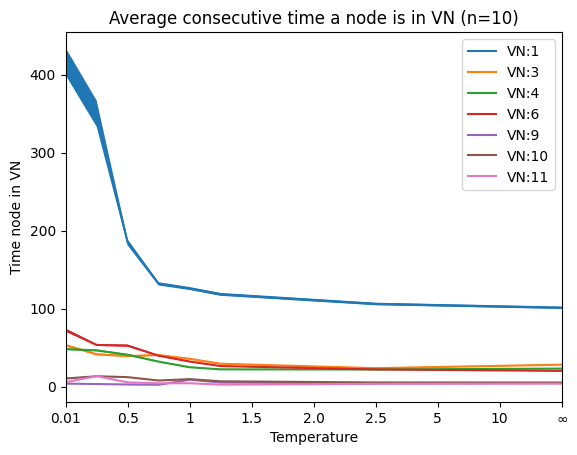

In [378]:
def getAllLengths(arr, n):
    # intitialize count
    result = []
    count = 0 
  
    for i in range(0, n):
      
        # Append and reset count when 0 is found
        if (arr[i] == 0):
            result.append(count)
            count = 0
  
        # If 1 is found, increment count
        # and update result if count 
        # becomes more.
        else:
            # increase count
            count+= 1 
#             result = max(result, count) 
            
    return result[result != 0]

fig, ax1 = plt.subplots()
# ax1.set_xticks(np.arange(9))
xl = np.array([str(i) for i in temperatures], dtype = object)
xl[-1] = r"$\infty$"
ax1.set_xticks(range(len(xl)))
ax1.set_xticklabels(xl)

ax1.set_xlabel('Temperature')
ax1.set_ylabel('Time node in VN')

for v in V_list[1:]:
    avg_max_time_in_VN = []
    std_max_time_in_VN = []
    for temp in temperatures:
        max_time_in_VN = []
        for node in range(100):
            for run in samples:
                max_time_in_VN.append(getAllLengths(VN_count_sample_nodes_vector[f'({v}, {temp}, {run})'][:,node], 1000))
        avg_max_time_in_VN.append(np.mean(max_time_in_VN)) 
        std_max_time_in_VN.append(np.std(max_time_in_VN)) 
        
    avg_max_time_in_VN = [avg*100 for avg in avg_max_time_in_VN]
    ax1.plot(temperatures, avg_max_time_in_VN,label=f'VN:{v}') 
    ax1.fill_between(temperatures, np.array(avg_max_time_in_VN)+np.array(std_max_time_in_VN), np.array(avg_max_time_in_VN)-np.array(std_max_time_in_VN))
ax1.legend()
plt.xlim(0, 8)
    import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.title('Average consecutive time a node is in VN (n=10)')

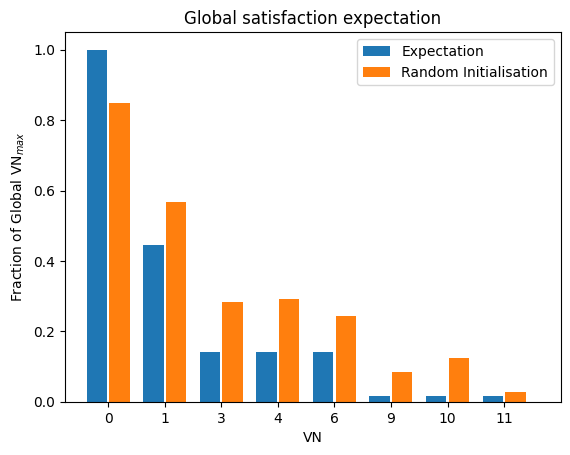

In [55]:
from matplotlib import pyplot as plt


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())


if __name__ == "__main__":
    # Usage example:
    data = {
        "Expectation": V_global_probabilities,
        "Random Initialisation": random_global_init,
    }

    fig, ax = plt.subplots()
    bar_plot(ax, data, total_width=.8, single_width=.9)
    plt.xlabel('VN')
    plt.ylabel(r"Fraction of Global VN$_{max}$")
    plt.title('Global satisfaction expectation')
#     plt.legend()
    plt.xticks = V_list


    ax.set_xticks(np.arange(9))
    xl = np.array([str(i) for i in V_list], dtype = object)
    ax.set_xticks(range(len(xl)))
    ax.set_xticklabels(xl)
    
    plt.show()


In [939]:
def neighbors(A, node):
    '''Return an numpy array containing the neighbors of a node'''
    nb = np.where(A[node]==1)[1]
    return nb

print(V.shape[0])
for node in range(V.shape[0]):
    print(node, 0)
    
edge_id = 0
for node in range(V.shape[0]):
    nb = neighbors(V, node)
    print(len(nb))
    for j in range(len(nb)):
        print(node, nb[j])
        edge_id += 1

5
0 0
1 0
2 0
3 0
4 0
2
0 1
0 4
2
1 0
1 2
2
2 1
2 3
1
3 2
1
4 0


In [1031]:
L = 10
G = nx.grid_2d_graph(L,L, periodic=True)
A = nx.adjacency_matrix(G).todense() 

print(G.nodes())
for i, node in enumerate(G.nodes()):
    G.nodes[node]["state"] = G_init[i]
    G.nodes[node]["pos"] = node
    
labels = nx.get_node_attributes(G, 'state') 
colors = ['red', 'green', 'blue', 'yellow', 'purple']
color_map = []

for node in G:
    color_map.append(colors[labels[node]])

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


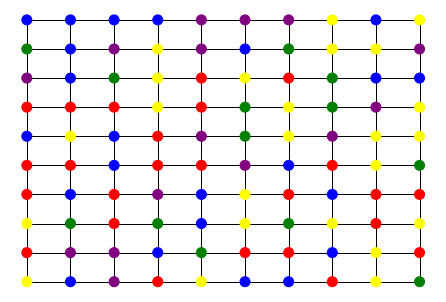

In [1032]:
pos = nx.get_node_attributes(G, 'pos')
# nx.draw(G, labels=labels, node_color=color_map, pos=pos, node_size=100)
nx.draw(G, node_color=color_map, pos=pos, node_size=100)

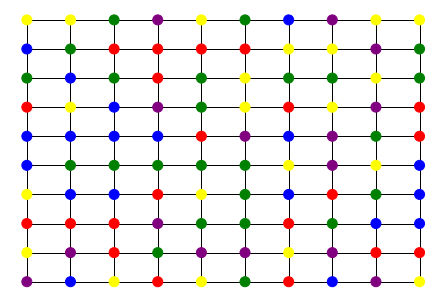

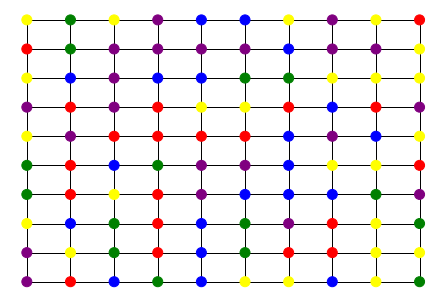

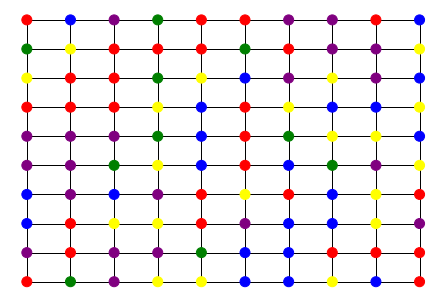

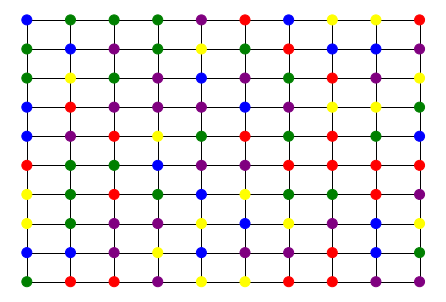

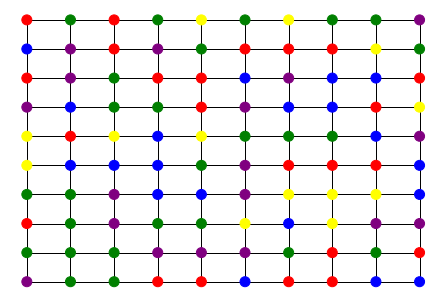

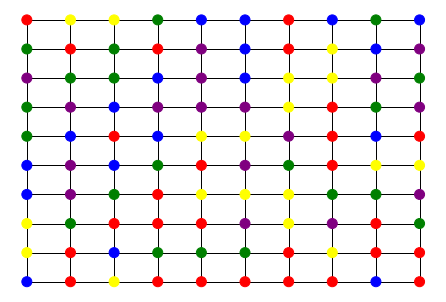

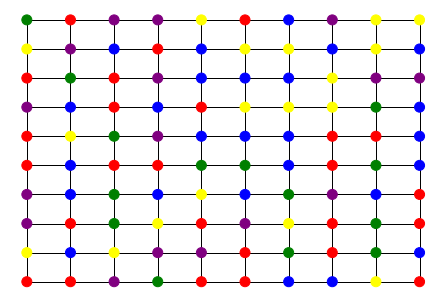

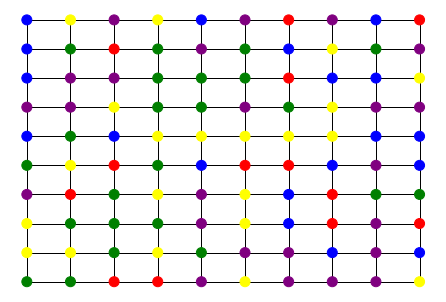

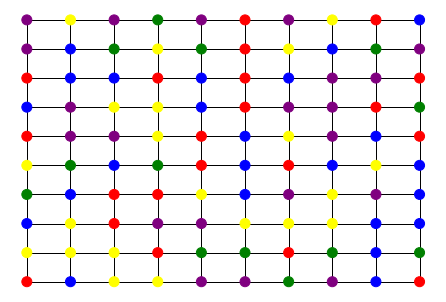

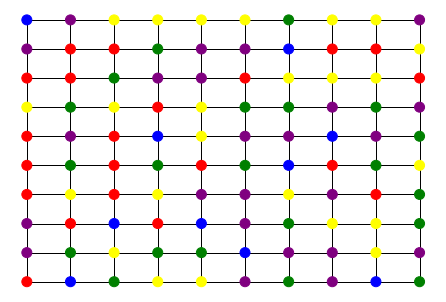

In [1061]:
#!/usr/bin/env python
import random
import pylab
from matplotlib.pyplot import pause
import networkx as nx
pylab.ion()

# G = nx.Graph()
# node_number = 0
# G.add_node(node_number, Position=(random.randrange(0, 100), random.randrange(0, 100)))

L = 10
G = nx.grid_2d_graph(L,L, periodic=True)
A = nx.adjacency_matrix(G).todense() 

node_number = 0

def update(G, G_time):
    for i, node in enumerate(G.nodes()):
        G.nodes[node]["state"] = G_time[i]
        G.nodes[node]["pos"] = node
    
        labels = nx.get_node_attributes(G, 'state') 
        colors = ['red', 'green', 'blue', 'yellow', 'purple']
        color_map = []

    for node in G:
#         print(node, colors[labels[node]])
        color_map.append(colors[labels[node]])

    pos = nx.get_node_attributes(G, 'pos')
    return G, color_map, pos, labels
    
# nx.draw(G, node_color=color_map, pos=pos, node_size=100)

def get_fig(G, G_time):
    global node_number
    node_number += 1
    
    G, color_map, pos, labels = update(G, G_time)
    
    nx.draw(G, pos=pos, node_color=color_map, node_size=100)

num_plots = 10;
pylab.show()

for i in range(num_plots):
    G_time = np.random.randint(0, 5, 100)
    get_fig(G, G_time)
    pylab.draw()
    pause(2)

In [1053]:
G_time = np.random.randint(0, 5, 100)

In [1051]:
G_time

array([2, 0, 4, 1, 0, 4, 0, 0, 1, 2, 1, 0, 2, 4, 3, 3, 4, 4, 2, 0, 3, 0,
       4, 3, 3, 4, 0, 1, 3, 3, 3, 0, 3, 4, 4, 0, 2, 4, 3, 3, 4, 1, 1, 4,
       1, 1, 1, 4, 4, 2, 0, 2, 3, 3, 1, 2, 0, 4, 1, 0, 1, 2, 3, 0, 3, 4,
       2, 0, 0, 4, 4, 2, 1, 3, 2, 2, 4, 2, 3, 4, 1, 1, 3, 4, 3, 2, 2, 0,
       2, 1, 2, 0, 4, 2, 1, 3, 1, 4, 0, 1])